In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras

from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))     # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

# **loading dataset**

In [ ]:
train = ('/content/drive/MyDrive/Csv  files/Pneomonia/TRAIN')
test = ('/content/drive/MyDrive/Csv  files/Pneomonia/TEST')
val = ('/content/drive/MyDrive/Csv  files/Pneomonia/VAL')

# **DATA VISUALIZATION**

In [ ]:
pneumonia = ("/content/drive/MyDrive/Csv  files/Pneomonia/TRAIN/PNEONO")
pneumonia_dir = ("/content/drive/MyDrive/Csv  files/Pneomonia/TRAIN/PNEONO")

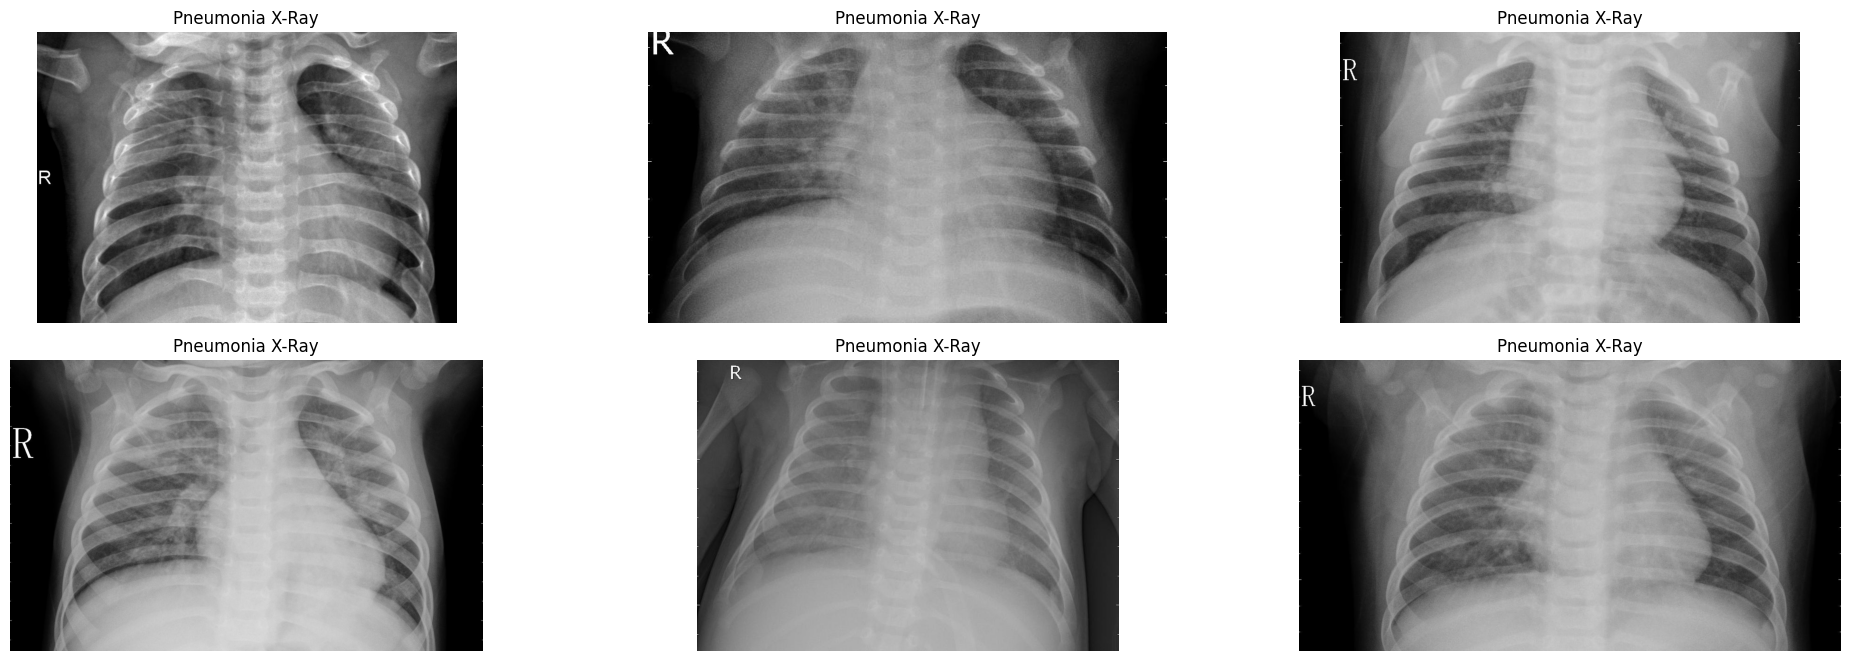

In [ ]:
import cv2 # import cv2 to read images
import os
plt.figure(figsize=(20, 10))

for i in range(6):
    plt.subplot(3, 3, i + 1)

    img_path = os.path.join(pneumonia_dir, os.listdir(pneumonia_dir)[i]) # get the actual image file path

    img = cv2.imread(img_path) # read the image data using cv2

    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Pneumonia X-Ray")
plt.tight_layout()


In [ ]:
normal = os.listdir("/content/drive/MyDrive/Csv  files/Pneomonia/TRAIN/NORMAL")
normal_dir = ("/content/drive/MyDrive/Csv  files/Pneomonia/TRAIN/NORMAL")


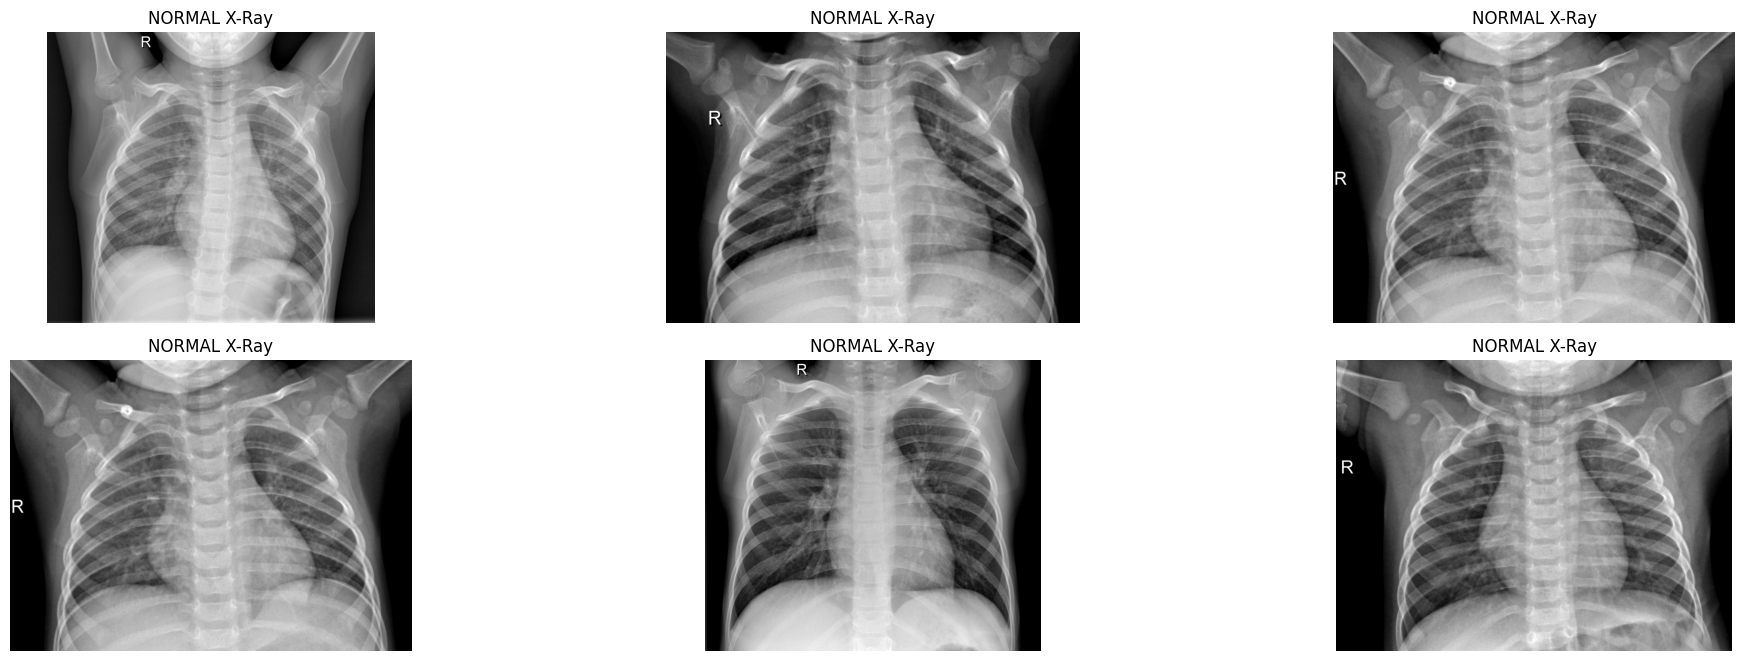

In [ ]:

plt.figure(figsize=(20, 10))

for i in range(6):
    plt.subplot(3, 3, i + 1)

    imgs_path = os.path.join(normal_dir, os.listdir(normal_dir)[i]) # get the actual image file path

    img = cv2.imread(imgs_path) # read the image data using cv2

    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("NORMAL X-Ray")
plt.tight_layout()


In [ ]:
class_names = ['NORMAL', 'PNEONO'] # Changed 'PNEUMONIA' to 'PNEONO'
images_path = []

for folder in [train, val, test] :
    for class_ in class_names :
        path = os.path.join(folder, class_)
        image_path = os.listdir(path)
        for image in image_path :
            image_filepath = os.path.join(path,image)
            images_path.append(image_filepath)

In [ ]:
# ordinal encoder
labels = [ class_names.index(os.path.basename(os.path.dirname(label))) for label in images_path ]
# Extract the class name using os.path.dirname and os.path.basename
labels[:5], images_path[:5]

([0, 0, 0, 0, 0],
 ['/content/drive/MyDrive/Csv  files/Pneomonia/TRAIN/NORMAL/N1.jpeg',
  '/content/drive/MyDrive/Csv  files/Pneomonia/TRAIN/NORMAL/N2.jpeg',
  '/content/drive/MyDrive/Csv  files/Pneomonia/TRAIN/NORMAL/N3.jpeg',
  '/content/drive/MyDrive/Csv  files/Pneomonia/TRAIN/NORMAL/N4.jpeg',
  '/content/drive/MyDrive/Csv  files/Pneomonia/TRAIN/NORMAL/N5.jpeg'])

In [ ]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(images_path, labels, test_size=0.2, random_state=42) # test
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

In [ ]:
len(X_train), len(X_val), len(X_test)

(22, 6, 8)

#image to tensor

In [ ]:
import tensorflow as tf
def preprocessing(image_path, image_size = (224,224)) :
    '''
    turn image path to tensor with resize image
    '''
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=1) # grayscale
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) # normalize scale between 0 to 1
    image = tf.image.resize(image, size=image_size)

    return image

## Label the images

In [ ]:
def get_image_label(image_path, label) :
    '''
    take an image to tensors and resize
    Return image and label tuple
    '''
    image = preprocessing(image_path)
    return image, label

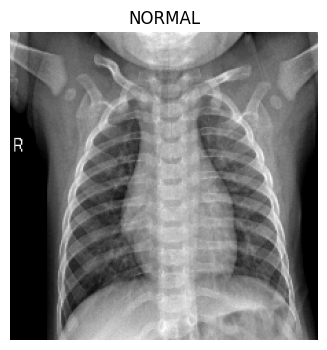

(224, 224, 1) 0


In [ ]:
def plot_image(image_tensor, label) :
    '''
    plot 1 images and title with the label
    '''
    plt.figure(figsize=(8,4))
    plt.imshow(image_tensor, cmap='gray')
    plt.title(class_names[label])
    plt.axis('off')
    plt.show()
sample_image = 5
image, label = get_image_label(X_train[sample_image], y_train[sample_image])
plot_image(image, label)
print(image.shape, label)

# create dataset (batch datasets)

In [ ]:
BATCH_SIZE = 32

def creat_dataset_batch(X, y=None, batch_size=32, valid_data=False, test_data=False) :
    '''
    create batches of data out of image and label.
    not shuffle in valid and test data ,and y=None because we want to predict it
    '''
    if test_data : # no label because we want to predict it
        print('creating... testing data')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
        data = data.map(preprocessing).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return data
    elif valid_data :
        print('creating... validation data')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        data = data.map(get_image_label).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return data
    else :
        print('creating... training data')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y))).shuffle(len(X)) # shuffle
        data = data.map(get_image_label).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return data
train_data = creat_dataset_batch(X_train, y_train, batch_size=BATCH_SIZE)
val_data = creat_dataset_batch(X_val, y_val, batch_size=BATCH_SIZE, valid_data=True)
test_data = creat_dataset_batch(X_test, y_test, batch_size=BATCH_SIZE, test_data=True)

creating... training data
creating... validation data
creating... testing data


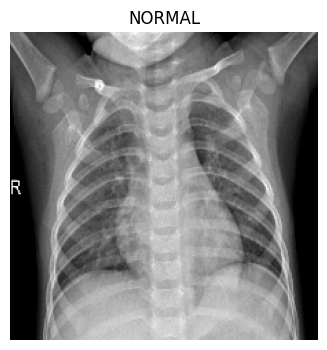

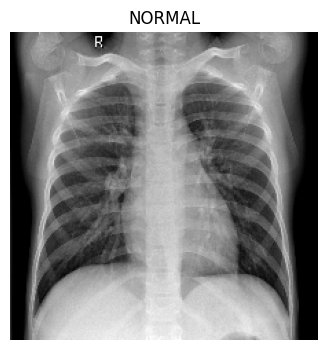

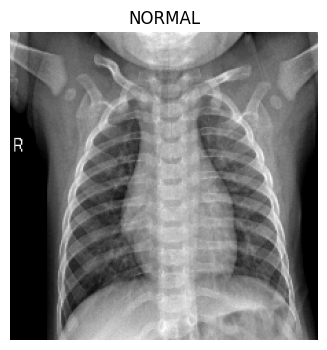

In [ ]:
import tensorflow as tf # Import tensorflow

# see first databatch
sample_images = []
sample_labels = []

for image, label in train_data.take(1) :
    sample_images.append(image)
    sample_labels.append(label)

# Use tf.TensorShape to access the class
tf.TensorShape(sample_images[0].shape), tf.TensorShape(sample_labels[0].shape)

for i in range(3) :
    plot_image(sample_images[0][i], sample_labels[0].numpy()[i])

# Building Model
*   evaluate
*   prediction
*   get recall






In [ ]:
inputs = keras.Input(shape=(224,224,1))
x = keras.layers.Conv2D(filters=16, kernel_size=(5,5), padding='valid')(inputs)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPool2D((2,2))(x)
x = keras.layers.Conv2D(filters=32, kernel_size=(5,5), padding='valid')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPool2D((2,2))(x)
x = keras.layers.Flatten()(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
x_rays_CNN_1_model = keras.Model(inputs = inputs,outputs = outputs, name='x_rays_CNN_1')
x_rays_CNN_1_model.summary()

Model: "x_rays_CNN_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 16)      416       
                                                                 
 activation (Activation)     (None, 220, 220, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 32)      12832     
                                                                 
 activation_1 (Activation)   (None, 106, 106, 32)      0         
                                                      

In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 75, 75, 64)        2

In [ ]:
import numpy as np
from keras.preprocessing import image

# Assuming X_test is a list of image file paths
def load_and_preprocess_images(image_paths):
    images = []
    for path in image_paths:
        img = image.load_img(path, target_size=(150, 150), color_mode='grayscale')  # Adjust target_size and color_mode if needed
        img_array = image.img_to_array(img)
        images.append(img_array)
    return np.array(images)

X_test_processed = load_and_preprocess_images(X_test)

predictions = (model.predict(X_test_processed) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

1/1 [==============================] - 0s 298ms/step


array([1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

AttributeError: 'numpy.ndarray' object has no attribute 'load_img'

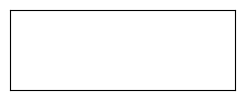

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming X_test, predictions, and y_test are already defined
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

# Some of the Correctly Predicted Classes
i = 0
for c in correct[:6]:
    plt.subplot(4, 2, i+1)
    plt.xticks([])
    plt.yticks([])


# Load and display the actual image from X_test
img = image.load_img(X_test[c], target_size=(150, 150), color_mode='grayscale')
plt.imshow(img, cmap="gray")

plt.title(f"Predicted Class {predictions[c]}, Actual Class {y_test[c]}")
plt.tight_layout()
i += 1

plt.show()


In [ ]:
i = 0
for c in correct[:6]:
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

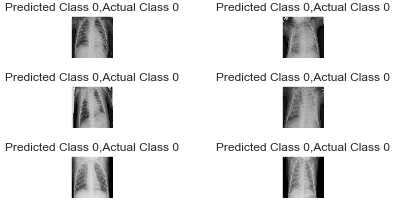

In [ ]:
i = 0
for c in incorrect[:6]:
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

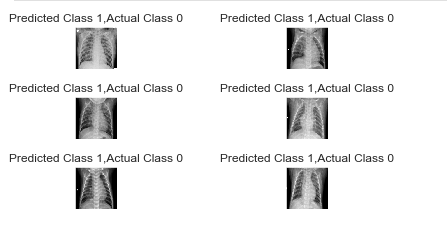